In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
!pipreqs ./

INFO: Successfully saved requirements file in ./requirements.txt


In [2]:
import pandas as pd
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
import ampligraph
from ampligraph.latent_features import TransE,RandomBaseline,DistMult,ComplEx,HolE,ConvE,ConvKB


In [5]:
# Knowledge Graph Construction.
def graph_construction(start, stop, step):
    kg = pd.DataFrame()
    kg['h'] = [i for i in np.arange(start, stop, step)]
    kg['r'] = ['isLessThan'] * int((stop-start) / step)
    kg['t'] = [i for i in np.arange(step, stop+1, step)]
    kg["h"] = kg.h.values.astype(str)
    kg["t"] = kg.t.values.astype(str)
    return kg

In [6]:
start = 0
stop = 1000
step = 5
kg_df = graph_construction(start, stop, step)
kg_df.head()

,h,r,t
0,0,isLessThan,5
1,5,isLessThan,10
2,10,isLessThan,15
3,15,isLessThan,20
4,20,isLessThan,25


In [7]:
#-RandomBaseline
kg_array = kg_df.to_numpy().astype(str)
model = RandomBaseline()
model.fit(kg_array)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [8]:
##kg embedding-TransE
kg_array = kg_df.to_numpy().astype(str)
model = TransE(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average TransE Loss:   1.715053: 100%|████████████████████████████████████████████| 200/200 [00:12<00:00, 15.44epoch/s]


In [34]:
#-DistMult
kg_array = kg_df.to_numpy().astype(str)
model = DistMult(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average DistMult Loss:   0.056055: 100%|██████████████████████████████████████████| 200/200 [00:12<00:00, 15.70epoch/s]


In [43]:
#-ComplEx
kg_array = kg_df.to_numpy().astype(str)
model = ComplEx(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average ComplEx Loss:   0.025238: 100%|███████████████████████████████████████████| 200/200 [00:18<00:00, 10.62epoch/s]


In [52]:
#-HolE
kg_array = kg_df.to_numpy().astype(str)
model = HolE(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average HolE Loss:   0.662338: 100%|██████████████████████████████████████████████| 200/200 [00:19<00:00, 10.06epoch/s]


In [61]:
#-ConvE
kg_array = kg_df.to_numpy().astype(str)
model = ConvE(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average Loss:   1.245033: 100%|███████████████████████████████████████████████████| 200/200 [03:25<00:00,  1.03s/epoch]


In [70]:
#-ConvKB
kg_array = kg_df.to_numpy().astype(str)
model = ConvKB(epochs=200, k=300, verbose=True)
model.fit(kg_array)

Average ConvKB Loss:   0.035850: 100%|████████████████████████████████████████████| 200/200 [00:26<00:00,  7.50epoch/s]


In [71]:
# Dimensionality reduction using t-SNE---visualize the embedding
embeddings = model.get_embeddings(entities=[str(j) for j in np.arange(start, stop+1, step)], embedding_type='entity')
embeddings = np.asarray(embeddings, dtype='float64')
embeddings_tSNE = TSNE(n_components=2).fit_transform(embeddings)
embeddings_tSNE = pd.DataFrame(embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
embeddings_tSNE['magnitude'] = [i for i in range(start, stop+1, step)]
embeddings_tSNE.head()

,tSNE_1,tSNE_2,magnitude
0,4.657066,0.191267,0
1,-5.533893,-0.457811,5
2,5.019544,-0.176834,10
3,-5.099383,-0.539453,15
4,5.202123,-1.956354,20


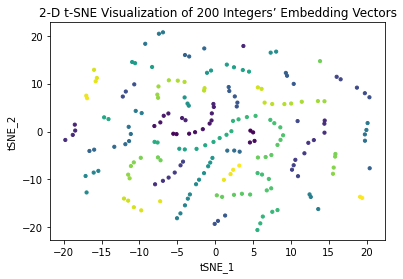

In [72]:
# Visualize the embedding vectors in 2-D space.
plt.scatter(embeddings_tSNE.tSNE_1, embeddings_tSNE.tSNE_2, c=embeddings_tSNE.magnitude, s=10)
plt.title('2-D t-SNE Visualization of 200 Integers’ Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

In [73]:
# Measure the similarity between numbers--处理oov number
def cal_sim(x1, x2, x3):
    return (x2-x1)/(x3-x1)

In [74]:
# Obtain embedding vectors for OOVs.
OOVs = range(0, 1000)
OOV_embeddings = []
for i in OOVs:
    for j in np.arange(start, stop+1, step):
        if i < j:
            upper = j
            lower = j-step
            e1 = model.get_embeddings(str(lower), embedding_type='entity')
            e2 = model.get_embeddings(str(upper), embedding_type='entity')
            s2 = cal_sim(lower, i, upper)
            s1 = 1-s2            
            OOV_embeddings.append(e1 * s1 + e2 * s2)
            break

In [75]:
# Dimensionality reduction using t-SNE.
OOV_embeddings = np.asarray(OOV_embeddings, dtype='float64')
OOV_embeddings_tSNE = TSNE(n_components=2).fit_transform(OOV_embeddings)
OOV_embeddings_tSNE = pd.DataFrame(OOV_embeddings_tSNE, columns=['tSNE_1', 'tSNE_2'])
OOV_embeddings_tSNE['magnitude'] = OOVs
OOV_embeddings_tSNE.head()

,tSNE_1,tSNE_2,magnitude
0,11.002681,17.660982,0
1,11.414953,17.419996,1
2,12.152664,16.916800,2
3,13.209444,16.621037,3
4,14.162666,16.316187,4


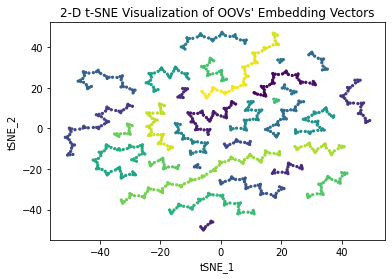

In [76]:
# Visualize the embedding vectors of OOVs in 2-D space.
plt.scatter(OOV_embeddings_tSNE.tSNE_1, OOV_embeddings_tSNE.tSNE_2, c=OOV_embeddings_tSNE.magnitude, s=5)
plt.title('2-D t-SNE Visualization of OOVs\' Embedding Vectors')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

In [77]:
OOV_embeddings.shape

(1000, 300)

In [78]:
np.save("covkb 1-999 300d.npy",OOV_embeddings)